In [1]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<!---
<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter, delivered by Fastly, rendered by Rackspace.
</footer>
-->
''')

# Velocities

ADCP measurements are aggregated and averaged over the period of the CTD cast. Then, the ADCP velocities are averaged over a certain depth (100 dBar and the mixed layer depth) and the according standard deviation of the velocity over that depth is determined.

In [2]:
%run ../_setup.py

import math
import numpy as np
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

from netCDF4 import Dataset, num2date

from gsw import sigma0, f

from OceanPy.interpolation import OI
from OceanPy.stability import mixed_layer_depth
from OceanPy.animations import play2D

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

import datetime

import pyproj

## ADCP velocities (at CTD locations) from surface to 100 dbar

The ADCP velocities are averaged over the first 100 dBar and the according standard deviation over that depth is determined by calculating the velocity magnitude, average it over the depth and calculating the standard deviation over the depth, which is than plotted as circles around the averaged velocity vectors.

In [3]:
input_file_adcp = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_adcp_ctd.nc')
input_file_ctd = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')

adcp = Dataset(input_file_adcp)
ctd = Dataset(input_file_ctd)

nst = ctd.dimensions['profile'].size

# find index of pressure closest to predefined pressure level
plevel = 100
pressure = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), 
                       adcp.dimensions['plevel'].size)
ip = (np.abs(pressure-plevel)).argmin()

# calculate mean of velocities from surface to pressure level
utdmean = np.nanmean(adcp['u_ctd'][:, slice(0, ip)], axis=1)
vtdmean = np.nanmean(adcp['v_ctd'][:, slice(0, ip)], axis=1)

# calculate magnitude of vectors and calculate standard deviation
Vadcp = np.sqrt(adcp['u_ctd'][:]**2 + adcp['v_ctd'][:]**2)
V100mean = np.nanmean([Vadcp[ist, slice(0, ip)] for ist in range(nst)], axis=1)
V100std = np.nanstd([Vadcp[ist, slice(0, ip)] for ist in range(nst)], axis=1)


In order to see if the ADCP velocity vectors follow the geostrophic current, the linearly interpolated dynamic height contours between 1500-1000 dbar are plotted in the background.

In [4]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p']):
    pressure_levels[p] = ip

# define reference and interest level 
p_ref = 1500
p_int = 1000
p_surf = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

D_s = np.array([ctd['deltaD'][profile, pressure_levels[p_surf]] / 
              ctd['g'][profile, pressure_levels[p_surf]]
              for profile in range(len(ctd.dimensions['profile']))])

# find finite values
mask = np.isfinite(D[2:])

# interpolate linearly dynamic height contours on grid
lon, lat = ctd['lon'][2:, 1], ctd['lat'][2:, 1]
nx, ny = 20, 20
xi = np.linspace(lon[mask].min(), lon[mask].max(), nx)
yi = np.linspace(lat[mask].min(), lat[mask].max(), ny)
xxD, yyD = np.meshgrid(xi, yi)
Dgrd = griddata((lon[mask], lat[mask]), D[2:][mask], (xxD, yyD), method='linear')
D_sgrd = griddata((lon[mask], lat[mask]), D_s[2:][mask], (xxD, yyD), method='linear')
# Vgrd = griddata((adcp['lon_ctd'][2:], adcp['lat_ctd'][2:]), vmagmean[2,:], (xx, yy), method='linear')


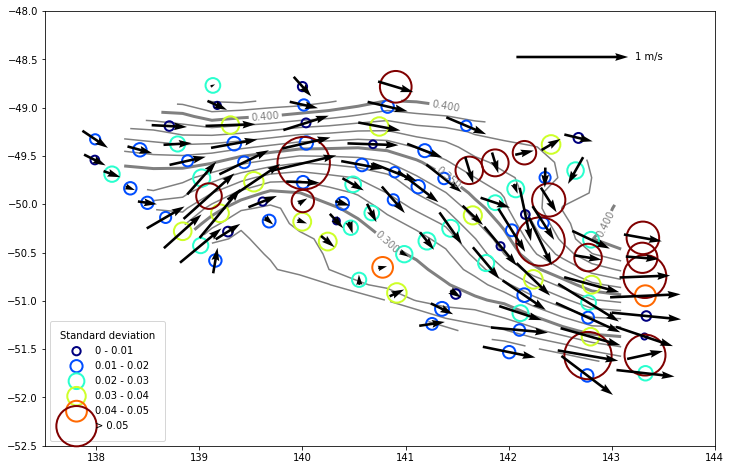

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

# plot dynamic height contours
step = 0.01
xmin, xmax = math.floor(np.nanmin(Dgrd)*100)/100, math.ceil(np.nanmax(Dgrd)*100)/100
nsteps = int((xmax - xmin) / step) + 2
bounds = np.linspace(xmin, xmax, nsteps)

ct = ax.contour(xxD, yyD, Dgrd, bounds, colors='gray', zorder=1)

for ib, b in enumerate(bounds):
    if b in bounds[4::5]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=3)
ax.clabel(ct, bounds[4::5], inline=1, fontsize=10)


# plot quiver plot
Q = ax.quiver(adcp['lon_ctd'][2:], adcp['lat_ctd'][2:], utdmean[2:], vtdmean[2:], 
              pivot='mid', units='inches', width=0.003*12, zorder=3)
qk = plt.quiverkey(Q, 0.8, 0.8, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'medium'})

# # plot contour of veocity magnitude
# conf = plt.contourf(xx, yy, Vgrd, zorder=0)

# plot standard deviation scatter
std_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
colors = cm.jet(np.linspace(0, 1, len(std_bins)))
for i in range(len(std_bins)):
    if i == len(std_bins)-1:
        criteria = (V100std[2:] > std_bins[i])
        label = '> %s' % (std_bins[i])
    else:
        criteria = (V100std[2:] > std_bins[i]) & (V100std[2:] <= std_bins[i + 1])
        label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(adcp['lon_ctd'][2:][criteria], adcp['lat_ctd'][2:][criteria], s=V100std[2:][criteria]*1e4, 
               label=label, color=colors[i], facecolors='none', linewidth=2, zorder=2)
legend = ax.legend(title='Standard deviation', borderpad=1, fontsize='medium', loc=3)
legend.get_title().set_fontsize('medium')

ax.set_xlim([137.5, 144]), ax.set_ylim([-52.5, -48])

plt.show()

As shown in the figure above the standard deviation is relatively large compared to when the velocity is averaged from the surface to the mixed layer depth, as seen in figure below.

In [6]:
smooth = True
imld = []
for ist in range(nst):
    
    # read variables
    sig0 = ctd['sigma0'][ist,]
    pt = ctd['pt'][ist,]
    z = ctd['z'][ist,]

    # determine index of mixed layer depth 
    imld_tdd = mixed_layer_depth(z, sig0=sig0, pt=pt, smooth=smooth)[0]
    imld.append(imld_tdd)
    
# construct adcp pressure levels
padcp = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), adcp.dimensions['plevel'].size)

# find reference depth
ref = 20
iref, ref_dep = min(enumerate(padcp), key=lambda x: abs(x[1] - ref))
print('reference depth: %s' %ref_dep)

# find pressure of mixed layer depth
pmld = [ctd['p'][i] for i in imld]
imldadcp = [(np.abs(padcp - p)).argmin() for p in pmld]

# calculate mean of velocities from surface to pressure level
umldmean = np.array([np.nanmean(adcp['u_ctd'][ist, slice(iref, imldadcp[ist])]) for ist in range(nst)])
vmldmean = np.array([np.nanmean(adcp['v_ctd'][ist, slice(iref, imldadcp[ist])]) for ist in range(nst)])

# calculate magnitude of vectors and calculate standard deviation
Vmldmean = np.array([np.nanmean(Vadcp[ist, slice(iref, imldadcp[ist])]) for ist in range(nst)])
Vmldstd = np.array([np.nanstd(Vadcp[ist, slice(iref, imldadcp[ist])]) 
                       if not all(Vadcp[ist, slice(iref, imldadcp[ist])].mask) else np.nan for ist in range(nst)])


reference depth: 16.8


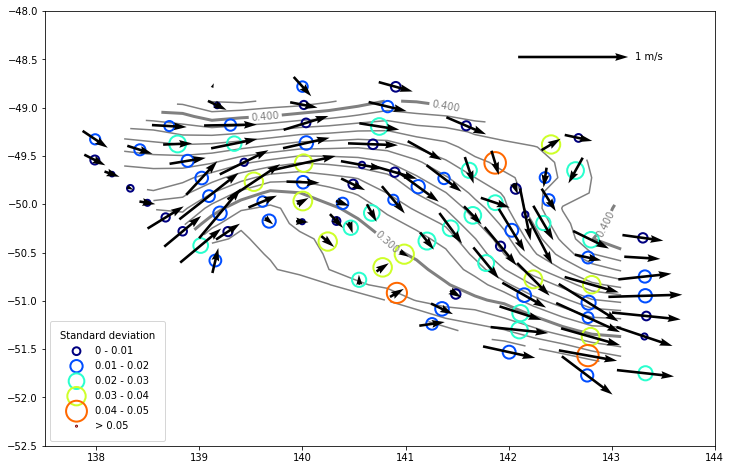

In [7]:
# PLOT

fig, ax = plt.subplots(figsize=(12, 8))

# plot dynamic height contours
ct = ax.contour(xxD, yyD, Dgrd, bounds, colors='gray', zorder=-1)

for ib, b in enumerate(bounds):
    if b in bounds[4::10]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=3)
ax.clabel(ct, bounds[4::10], inline=1, fontsize=10)

# plot quiver plot
Q = ax.quiver(adcp['lon_ctd'][2:], adcp['lat_ctd'][2:], umldmean[2:], vmldmean[2:], 
              pivot='mid', units='inches', width=0.003*12, zorder=2)
qk = plt.quiverkey(Q, 0.8, 0.8, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'medium'})

# plot standard deviation scatter
std_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
for i in range(len(std_bins)):
    if i == len(std_bins)-1:
        criteria = (Vmldstd[2:] > std_bins[i])
        label = '> %s' % (std_bins[i])
    else:
        criteria = (Vmldstd[2:] > std_bins[i]) & (Vmldstd[2:] <= std_bins[i + 1])
        label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(adcp['lon_ctd'][2:][criteria], adcp['lat_ctd'][2:][criteria], s=Vmldstd[2:][criteria]*1e4, 
               label=label, color=colors[i], facecolors='none', linewidth=2, zorder=1)
legend = ax.legend(title='Standard deviation', borderpad=1, fontsize='medium', loc=3)
legend.get_title().set_fontsize('medium')

ax.set_xlim([137.5, 144]), ax.set_ylim([-52.5, -48])

plt.show()

Now, lets focus on the geostropic velocities. From SSH altimetry geostrophic velocities are determined and shown from January 1, 1998 to April 31, 1998. The date in the title in the movie below is shown in red at at the time of the voyage. Good job, Steve! The voyage is timed pretty well.

In [8]:
input_file = os.path.join(datadir, 'external', 'ssh', 'SSH_OceanCurrent_137_-52.4_147_-48_199801-199804.nc')
ssh = Dataset(input_file)

time = ssh['TIME']
time = num2date(time[:], time.units)
begin = datetime.datetime(1998, 3, 10)
end = datetime.datetime(1998, 3, 28)

timevoy = np.array([begin <= t <= end for t in time])

V = np.ma.masked_all(ssh['UCUR'].shape)
for t in range(len(time)):
    V[t,] = np.sqrt(ssh['UCUR'][t,]**2 + ssh['VCUR'][t,]**2)

anim = play2D(ssh['LONGITUDE'][:], ssh['LATITUDE'][:], V, time=time, mask=timevoy, cmin=0, cmax=0.6, interval=200)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())
display_animation(anim)

In [9]:
input_file_ssh = os.path.join(datadir, 'external', 'ssh', 'SSH_OceanCurrent_137.5_-52_144_-48.5_199803.nc')
ssh = Dataset(input_file_ssh)

# lon, lat = adcp['lon_ctd'][2:], adcp['lat_ctd'][2:]
loni, lati = ssh['LONGITUDE'][:], ssh['LATITUDE'][:]
# lonlon, latlat = np.meshgrid(loni, lati)
# monthly mean ssh
ummean = np.mean(ssh['UCUR'][:], axis=0)
vmmean = np.mean(ssh['VCUR'][:], axis=0)

# monthly mean geostrophic velocity magnitude
Vssh = np.ma.masked_array([np.sqrt(ssh['UCUR'][t,::]**2 + ssh['UCUR'][t,::]**2) 
                        for t in range(ssh.dimensions['TIME'].size)])

Vmmean = np.mean(Vssh, axis=0)

The mixed layer depth velocities are used as observations in OI, with the monthly mean geostrophic velocities from SSH as a background field to obtain a field of absolute velocities on a rectangular grid. 

In [10]:
# optimal interpolation of ADCP velocities with SSH geostrophic velocities as background field
mask = np.ma.masked_invalid(umldmean[2:]).mask
xx, yy, u_b, u_a = OI(lon[~mask], lat[~mask], umldmean[2:][~mask],
                      Lx=(lon.max() - lon.min())/12, Ly=(lat.max() - lat.min())/14,
                      xx=loni, yy=lati, bg_fld=ummean)[0:4]
v_b, v_a = OI(lon[~mask], lat[~mask], vmldmean[2:][~mask],
              Lx=(lon.max() - lon.min())/12, Ly=(lat.max() - lat.min())/14,
              xx=loni, yy=lati, bg_fld=vmmean)[2:4]

Vmld_a = np.sqrt(u_a**2 + v_a**2)

First the velocity magnitude of the background and analysis field and for comparison the linear interpolated MLD velocity field is shown.

In [11]:
xx, yy = np.meshgrid(loni, lati)
mask = np.isfinite(Vmldmean[2:])
Vmld = griddata((lon[mask], lat[mask]), Vmldmean[2:][mask], (xx, yy), method='linear')

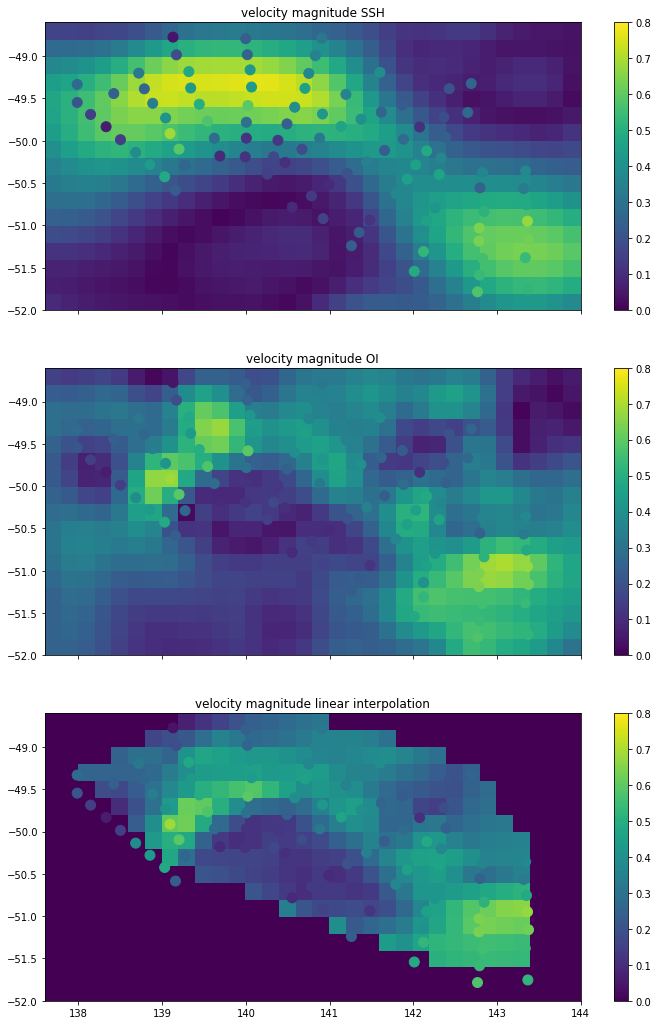

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
vmin, vmax = 0, 0.8
ax[0].pcolor(xx, yy, Vmmean.data, vmin=vmin, vmax=vmax)
scat = ax[0].scatter(lon, lat, c=Vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[0])
ax[0].set_title('velocity magnitude SSH')

ax[1].pcolor(xx, yy, Vmld_a, vmin=vmin, vmax=vmax)
scat = ax[1].scatter(lon, lat, c=Vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[1])
ax[1].set_title('velocity magnitude OI')

ax[2].pcolor(xx, yy, Vmld, vmin=vmin, vmax=vmax)
scat = ax[2].scatter(lon, lat, c=Vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[2])
ax[2].set_title('velocity magnitude linear interpolation')

Here, the u-component of the velocity vector is shown.

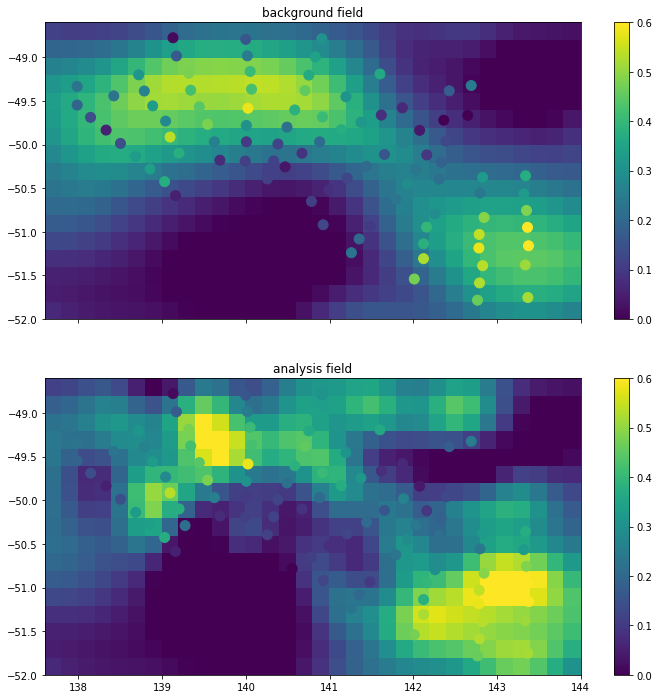

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
vmin, vmax = 0, 0.6
ax[0].pcolor(xx, yy, u_b, vmin=vmin, vmax=vmax)
scat = ax[0].scatter(lon, lat, c=umldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[0])
ax[0].set_title('background field')

ax[1].pcolor(xx, yy, u_a, vmin=vmin, vmax=vmax)
scat = ax[1].scatter(lon, lat, c=umldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[1])
ax[1].set_title('analysis field')

And here, the v-component of the velocity vector.

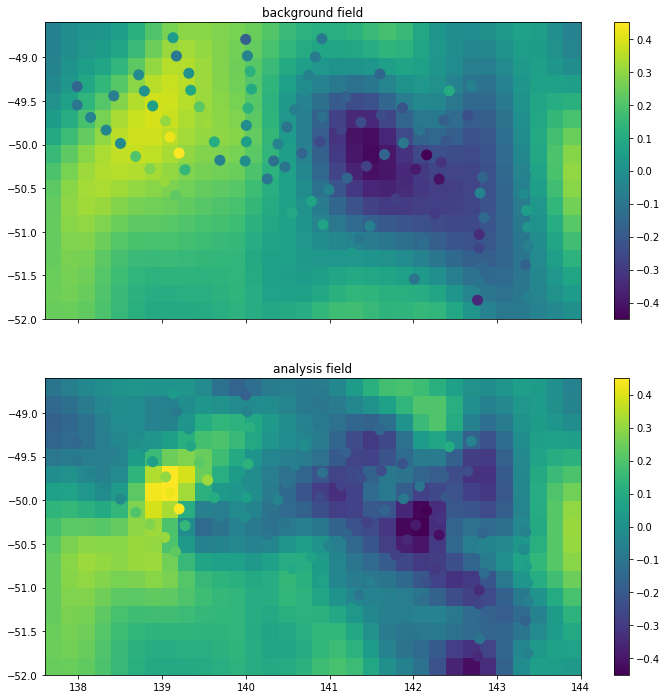

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
vmin, vmax = -0.45, 0.45
ax[0].pcolor(xx, yy, v_b, vmin=vmin, vmax=vmax)
scat = ax[0].scatter(lon, lat, c=vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[0])
ax[0].set_title('background field')

vmin, vmax = -0.45, 0.45
ax[1].pcolor(xx, yy, v_a, vmin=vmin, vmax=vmax)
scat = ax[1].scatter(lon, lat, c=vmldmean[2:], s=100, vmin=vmin, vmax=vmax)
plt.colorbar(scat, ax=ax[1])
ax[1].set_title('analysis field')

## Multivariate OI with Dynamic Height observations

The next step is to calculate geostrophic velocities from dynamic height observations and SSH and SSH geostrophic velocties as a background field. The dynamic height is used in OI scheme to derive geostrophic u and v components.

In [15]:
# monthly mean ssh
gslmmean = np.mean(ssh['GSL'][:], axis=0)
ummean = np.mean(ssh['UCUR'][:], axis=0)
vmmean = np.mean(ssh['VCUR'][:], axis=0)

mask = ~np.ma.masked_invalid(D_s[2:]).mask

# optimal interpolation of ADCP velocities with SSH geostrophic velocities as background field
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

lonlon, latlat = np.meshgrid(loni, lati)

xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)
x, y = pyproj.transform(WGS84, UTM54, lon, lat)

xx, yy, x_b, x_a, B, A = OI(x[mask], y[mask], D_s[2:][mask],
                            Lx=(xx.max() - xx.min())/20, Ly=(yy.max() - yy.min())/20,
                            xx=xx, yy=yy, bg_fld=(gslmmean, ummean, vmmean), mvoi='geostrophy', f_cor=f(latlat)/2)

# vmagmld_a = np.sqrt(u_a**2 + v_a**2)

In [16]:
print(ssh['GSL'],'\n\n', ssh['GSLA'])

<class 'netCDF4._netCDF4.Variable'>
float64 GSL(TIME, LATITUDE, LONGITUDE)
    long_name: gridded sea level
    standard_name: sea_surface_height_above_geoid
    description: GSLA + OFAM3 mean dynamic height 
    units: m
    coordinates: TIME LATITUDE LONGITUDE
    _FillValue: -4.99992370256
    missing_value: -4.99992370256
unlimited dimensions: TIME
current shape = (15, 18, 33)
filling on 

 <class 'netCDF4._netCDF4.Variable'>
float64 GSLA(TIME, LATITUDE, LONGITUDE)
    long_name: gridded (adjusted) sea level anomaly 
    standard_name: sea_surface_height_above_sea_level
    description: Altimeter and tidegauge estimates of adjusted sea level anomaly mapped onto a grid using optimal interpolation (OI). For details of  the temporal and spatial covariance functions of the OI see the Reference. The anomaly field is mapped because the geoid is not known to sufficient precision, obliging us to remove the time-mean from all sea level observations. Sea level minus the tides and inverse bar

**Question**
1. I used GSL instead of GSLA, to be in same order of magnitude as Dynamic height from observations, is that okay looking at the description of the variables above?

The covariance between the Dynamic Height and the geostrophic u and v components, the covariances between the u, and v components and the variance between p, u and v are shown below.

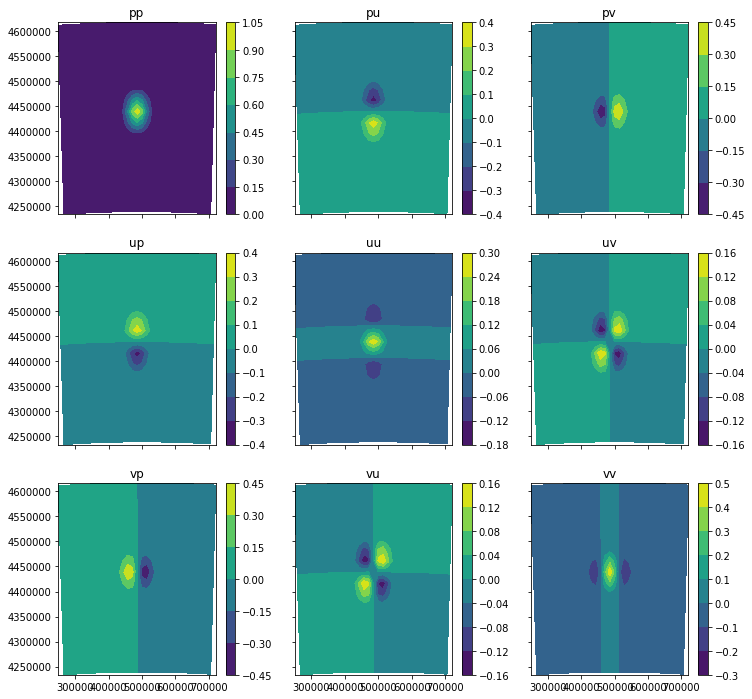

In [17]:
ny, nx = xx.shape 
# plot covariance matrices
var = ['p', 'u', 'v']
nvar = len(var)
coord = (int(np.floor(ny/2)), int(np.floor(nx/2)))
fig, ax = plt.subplots(nvar, nvar, figsize=(12, 12), sharex=True, sharey=True)
for ivar in range(nvar):
    for jvar in range(nvar):
        BB = np.reshape(B[ivar::nvar, jvar::nvar], (ny, nx, ny, nx))
        BBi = np.ma.masked_invalid(BB[coord[0], coord[1], :, :])
        conf = ax[ivar, jvar].contourf(xx, yy, BBi)
        ax[ivar, jvar].set_title(var[ivar] + var[jvar])
        # ax[ivar, jvar].set_xlim([-np.sqrt(2)*Lx, np.sqrt(2)*Lx])
        # ax[ivar, jvar].set_ylim([-np.sqrt(2)*Lx, np.sqrt(2)*Lx])
        plt.colorbar(conf, ax=ax[ivar, jvar])

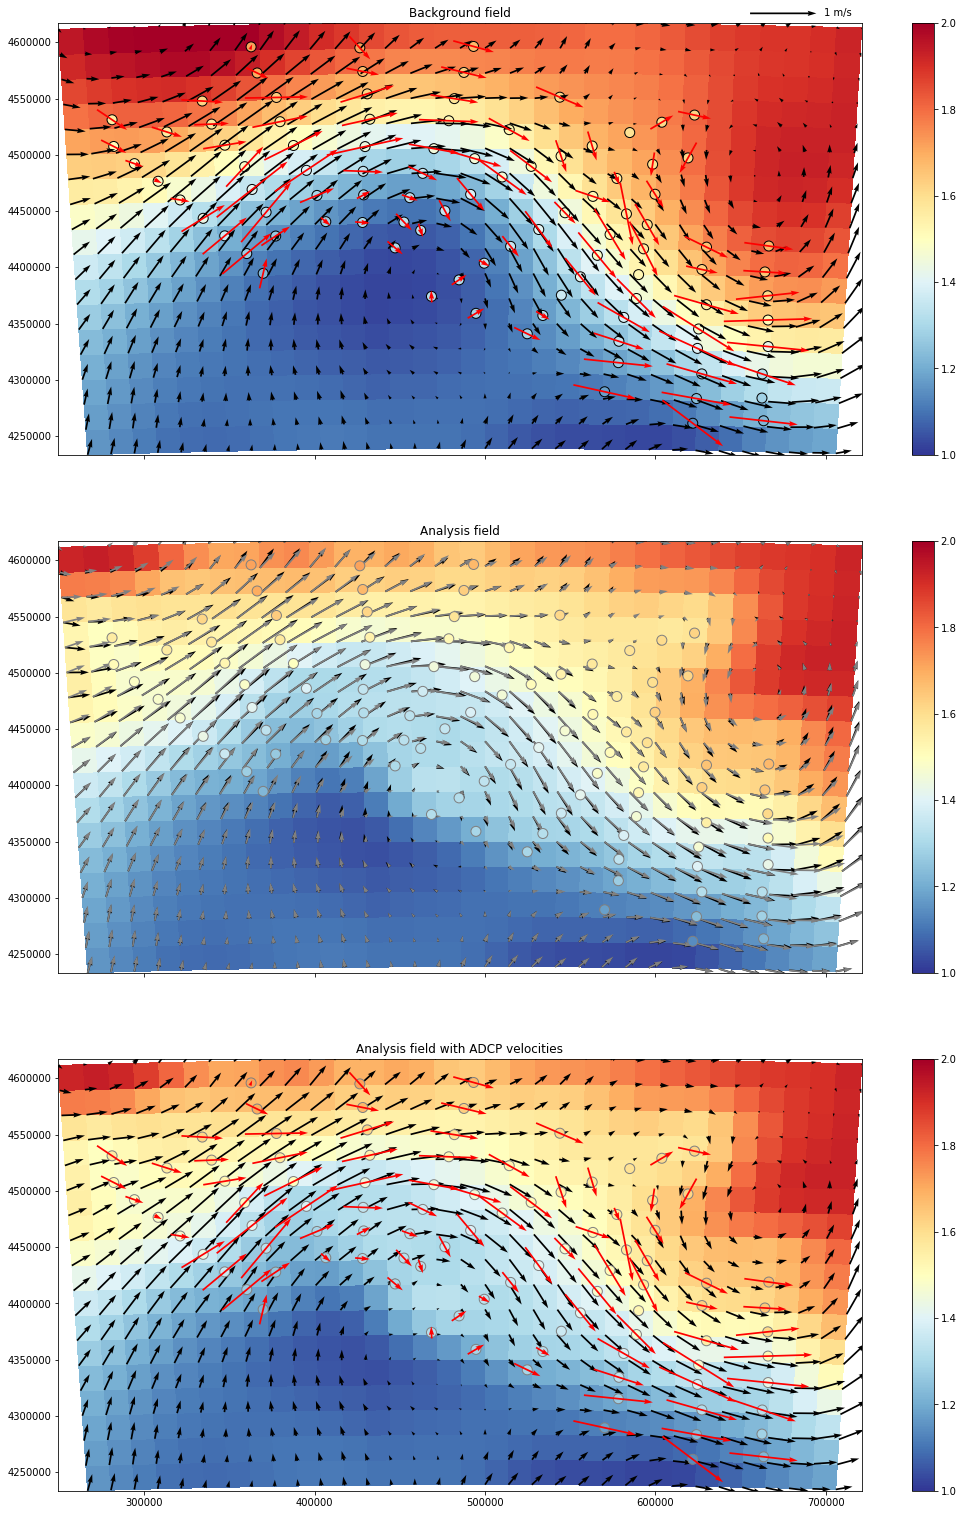

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(18, 27), sharex=True)
vmin, vmax = 1,2 #np.nanmin(D_s[2:]), np.nanmax(D_s[2:])

# Dynamic heighy background field
pcol = ax[0].pcolor(xx, yy, x_b[0], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r)

# Dynamic height measurements
ax[0].scatter(x[mask], y[mask], c=D_s[2:][mask], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, edgecolors='k', s=100)
plt.colorbar(pcol, ax=ax[0])

# Monthly mean geostropic velocity vectors from SSH
qb = ax[0].quiver(xx, yy, x_b[1], x_b[2], units='inches', width=0.002*12)
ax[0].quiverkey(qb, 0.71, 0.885, 1, '1 m/s', labelpos='E',
                coordinates='figure', fontproperties={'size': 'medium'})

# Velocity vectors ADCP mixed layer depth
ax[0].quiver(x[mask], y[mask], 
                 umldmean[2:][mask], vmldmean[2:][mask], color='r', 
                 pivot='mid', units='inches', width=0.002*12, zorder=4)#)

ax[0].set_title('Background field')


# Dynamic height analysis field
pcol = ax[1].pcolor(xx, yy, x_a[0], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, zorder=0)
# pcol = ax[1].contourf(xx, yy, x_a[0], np.linspace(vmin, vmax, 10), cmap=plt.cm.RdYlBu_r, zorder=0)

# # Dynamic height measurements
ax[1].scatter(x[mask], y[mask], c=D_s[2:][mask], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, 
              edgecolors='gray', s=100, zorder=2)
plt.colorbar(pcol, ax=ax[1])

# Monthly mean geostropic velocity vectors from SSH
qb = ax[1].quiver(xx, yy, ummean, vmmean, color='k', units='inches', width=0.002*12)

# Velocity vectors analysis field
ax[1].quiver(xx, yy, x_a[1], x_a[2], color='gray', units='inches', width=0.002*12)

ax[1].set_title('Analysis field')


# Dynamic height analysis field
pcol = ax[2].pcolor(xx, yy, x_a[0], vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, zorder=0)

# Dynamic height measurements
ax[2].scatter(x[mask], y[mask], c=D_s[2:][mask], 
              vmin=vmin, vmax=vmax, cmap=plt.cm.RdYlBu_r, edgecolors='gray', s=100, zorder=2)
plt.colorbar(pcol, ax=ax[2])

# Velocity vectors analysis field
qb = ax[2].quiver(xx, yy, x_a[1], x_a[2], color='k', units='inches', width=0.002*12)

# Velocity vectors ADCP mixed layer depth
ax[2].quiver(x[mask], y[mask], 
                 umldmean[2:][mask], vmldmean[2:][mask], color='r', 
                 pivot='mid', units='inches', width=0.002*12, zorder=4)#)

ax[2].set_title('Analysis field with ADCP velocities')


In [19]:
print('u_b: ', np.mean(x_b[1]), 'v_b: ', np.mean(x_b[2]), 
      'u_a: ', np.mean(x_a[1]), 'v_a: ', np.mean(x_a[2]), 
      np.mean(ummean), np.mean(vmmean))


u_b:  0.190111413612 v_b:  0.0686297766242 u_a:  0.187912037829 v_a:  0.0671439808621 0.190111413612 0.0686297766242


## relative vorticity

$$ \zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} $$

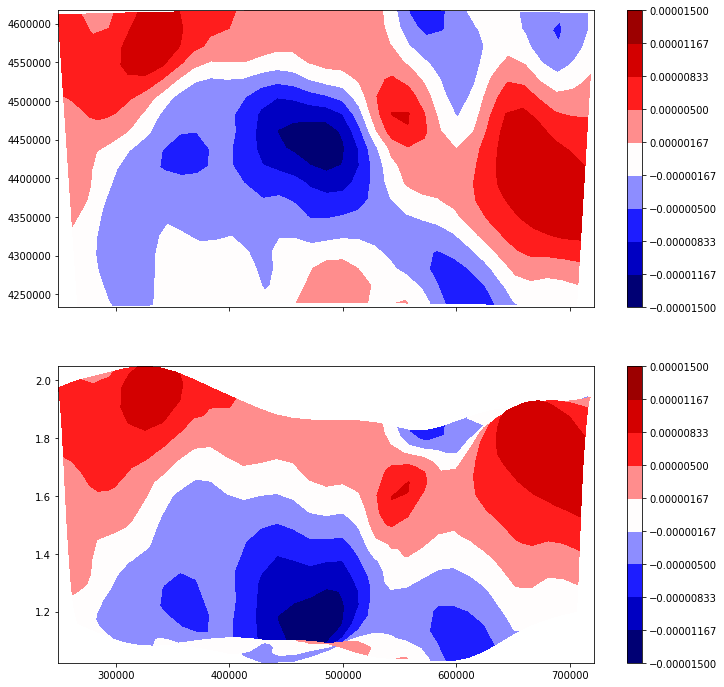

In [20]:
dvdx = np.gradient(x_b[2])[1] / np.gradient(xx)[1]
dudy = np.gradient(x_b[1])[0] / np.gradient(yy)[0]

zeta = dvdx - dudy

fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
vmin, vmax = -1.5e-5, 1.5e-5
cf = ax[0].contourf(xx, yy, zeta, np.linspace(vmin, vmax, 10), cmap=plt.cm.seismic)
plt.colorbar(cf, ax=ax[0])

cf = ax[1].contourf(xx, x_b[0], zeta, np.linspace(vmin, vmax, 10), cmap=plt.cm.seismic)
plt.colorbar(cf, ax=ax[1])


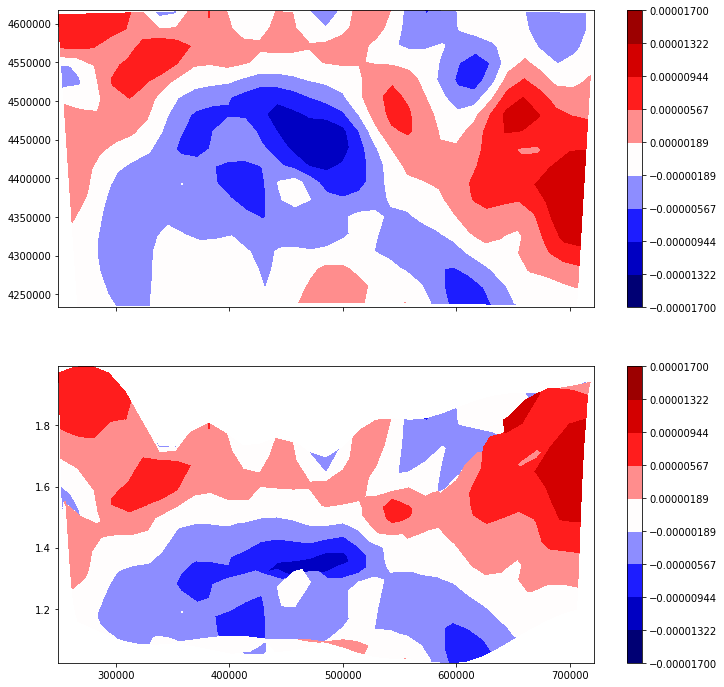

In [21]:
dvdx = np.gradient(x_a[2])[1] / np.gradient(xx)[1]
dudy = np.gradient(x_a[1])[0] / np.gradient(yy)[0]

zeta = dvdx - dudy

fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
vmin, vmax = -1.7e-5, 1.7e-5
cf = ax[0].contourf(xx, yy, zeta, np.linspace(vmin, vmax, 10), cmap=plt.cm.seismic)
plt.colorbar(cf, ax=ax[0])

cf = ax[1].contourf(xx, x_a[0], zeta, np.linspace(vmin, vmax, 10), cmap=plt.cm.seismic)
plt.colorbar(cf, ax=ax[1])